In [24]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [25]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"

# tags = ['2024-04-12-15-31-26']
# filters = {"tags": {"$in": tags}}
tags = ["2024-05-23-20-23-11"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [26]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 4
df

100%|██████████| 12/12 [00:00<00:00, 49833.31it/s]


,Evaluation/Timesteps,Evaluation/Mean_Discounted_Returns,_step,_wandb,Evaluation/Returns,_runtime,Evaluation/Mean_Entropy,Evaluation/Entropies,Evaluation/Discounted_Returns,trajectories,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,"{'_type': 'histogram', 'bins': [6, 6.046875, 6...",0.578025,0,{'runtime': 23},"{'bins': [0.5, 0.515625, 0.53125, 0.546875, 0....",24.970329,0.492160,"{'_type': 'histogram', 'bins': [0.397329539060...","{'_type': 'histogram', 'bins': [0.430467128753...","[[0, 4, 8, 9, 10, 14], [0, 4, 8, 9, 10, 14], [...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
1,"{'bins': [6, 6.828125, 7.65625, 8.484375, 9.31...",0.328367,0,{'runtime': 23},"{'_type': 'histogram', 'bins': [0.5, 0.515625,...",24.675004,0.669850,"{'values': [1, 0, 1, 0, 4, 2, 9, 1, 0, 1, 0, 0...","{'_type': 'histogram', 'bins': [0.002218527719...","[[0, 1, 1, 1, 1, 1, 0, 1, 0, 4, 0, 0, 1, 0, 0,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
2,"{'bins': [8, 9.4375, 10.875, 12.3125, 13.75, 1...",0.009774,0,{'runtime': 153},"{'bins': [0, 0.015625, 0.03125, 0.046875, 0.06...",154.946085,0.944542,"{'_type': 'histogram', 'bins': [0.782780885696...","{'_type': 'histogram', 'bins': [0, 0.007473387...","[[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
3,"{'bins': [6, 6.078125, 6.15625, 6.234375, 6.31...",0.554943,0,{'runtime': 12},"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",13.858811,0.546895,"{'_type': 'histogram', 'bins': [0.463915348052...","{'_type': 'histogram', 'bins': [0.348678350448...","[[0, 1, 2, 6, 10, 14], [0, 1, 2, 6, 10, 14], [...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
4,"{'bins': [6, 6.34375, 6.6875, 7.03125, 7.375, ...",0.407652,0,{'runtime': 12},"{'_type': 'histogram', 'bins': [0.5, 0.515625,...",13.484594,0.622301,"{'values': [1, 0, 0, 2, 1, 1, 2, 4, 4, 1, 1, 1...","{'_type': 'histogram', 'bins': [0.058149695396...","[[0, 1, 2, 1, 2, 3, 3, 3, 2, 1, 0, 0, 0, 1, 2,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
5,"{'_type': 'histogram', 'bins': [10, 11.40625, ...",0.018309,0,{'runtime': 60},"{'values': [67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",61.932166,0.925537,"{'bins': [0.8706887364387512, 0.87194299697875...","{'values': [79, 5, 2, 2, 0, 1, 0, 0, 1, 0, 1, ...","[[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
6,"{'values': [50, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0,...",0.521616,0,{'runtime': 7},"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",9.085561,0.571736,"{'_type': 'histogram', 'bins': [0.432753175497...","{'_type': 'histogram', 'bins': [0.205891042947...","[[0, 1, 2, 6, 10, 14], [0, 0, 4, 8, 9, 13, 14]...",...,0.3,4,identity,coordinate,0.000001,PolicyUCT,6,mvc,15,identity
7,"{'_type': 'histogram', 'bins': [6, 6.359375, 6...",0.336318,0,{'runtime': 10},"{'_type': 'histogram', 'bins': [0.5, 0.515625,...",11.212692,0.719267,"{'values': [1, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1...","{'_type': 'histogram', 'values': [2, 0, 0, 2, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 2,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,mvc,15,identity
8,"{'_type': 'histogram', 'bins': [11, 12.390625,...",0.011654,0,{'runtime': 33},"{'values': [81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",34.688839,0.954880,"{'bins': [0.8770565986633301, 0.87855416536331...","{'values': [89, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
9,"{'bins': [6, 6.125, 6.25, 6.375, 6.5, 6.625, 6...",0.515305,0,{'runtime': 5},"{'bins': [0.5, 0.515625, 0.53125, 0.546875, 0....",6.886123,0.544254,"{'_type': 'histogram', 'bins': [0.399550259113...","{'_type': 'histogram', 'bins': [0.254186

In [27]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']
policy_combination_mapping = {
    'mvc+PolicyUCT': 'MVC+MVCUCT',
    'mvc+UCT': 'MVC+UCT',
    'visit+UCT': 'Visit+UCT'
}

# Rename the policy combinations in the DataFrame
df['policy_combination'] = df['policy_combination'].map(policy_combination_mapping)
# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()
aggregated_trajectories


policy_combination  planning_budget
MVC+MVCUCT          16                 [[0, 4, 8, 9, 13, 14], [0, 0, 1, 2, 2, 2, 6, 1...
                    32                 [[0, 1, 2, 6, 10, 14], [0, 0, 4, 8, 9, 13, 14]...
                    64                 [[0, 1, 2, 6, 10, 14], [0, 1, 2, 6, 10, 14], [...
                    128                [[0, 4, 8, 9, 10, 14], [0, 4, 8, 9, 10, 14], [...
MVC+UCT             16                 [[0, 0, 0, 4, 8, 9, 13, 14], [0, 0, 0, 4, 0, 0...
                    32                 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 2,...
                    64                 [[0, 1, 2, 1, 2, 3, 3, 3, 2, 1, 0, 0, 0, 1, 2,...
                    128                [[0, 1, 1, 1, 1, 1, 0, 1, 0, 4, 0, 0, 1, 0, 0,...
Visit+UCT           16                 [[0, 4, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,...
                    32                 [[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,...
                    64                 [[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 

In [28]:
# remove all trajectories with a length of 100
print(aggregated_trajectories.apply(lambda x: len(x)).sum())
filtered_aggregated_trajectories = aggregated_trajectories.apply(lambda x: [traj for traj in x if len(traj) != 100])
# check the total number of trajectories
filtered_aggregated_trajectories.apply(lambda x: len(x)).sum()

1200


935

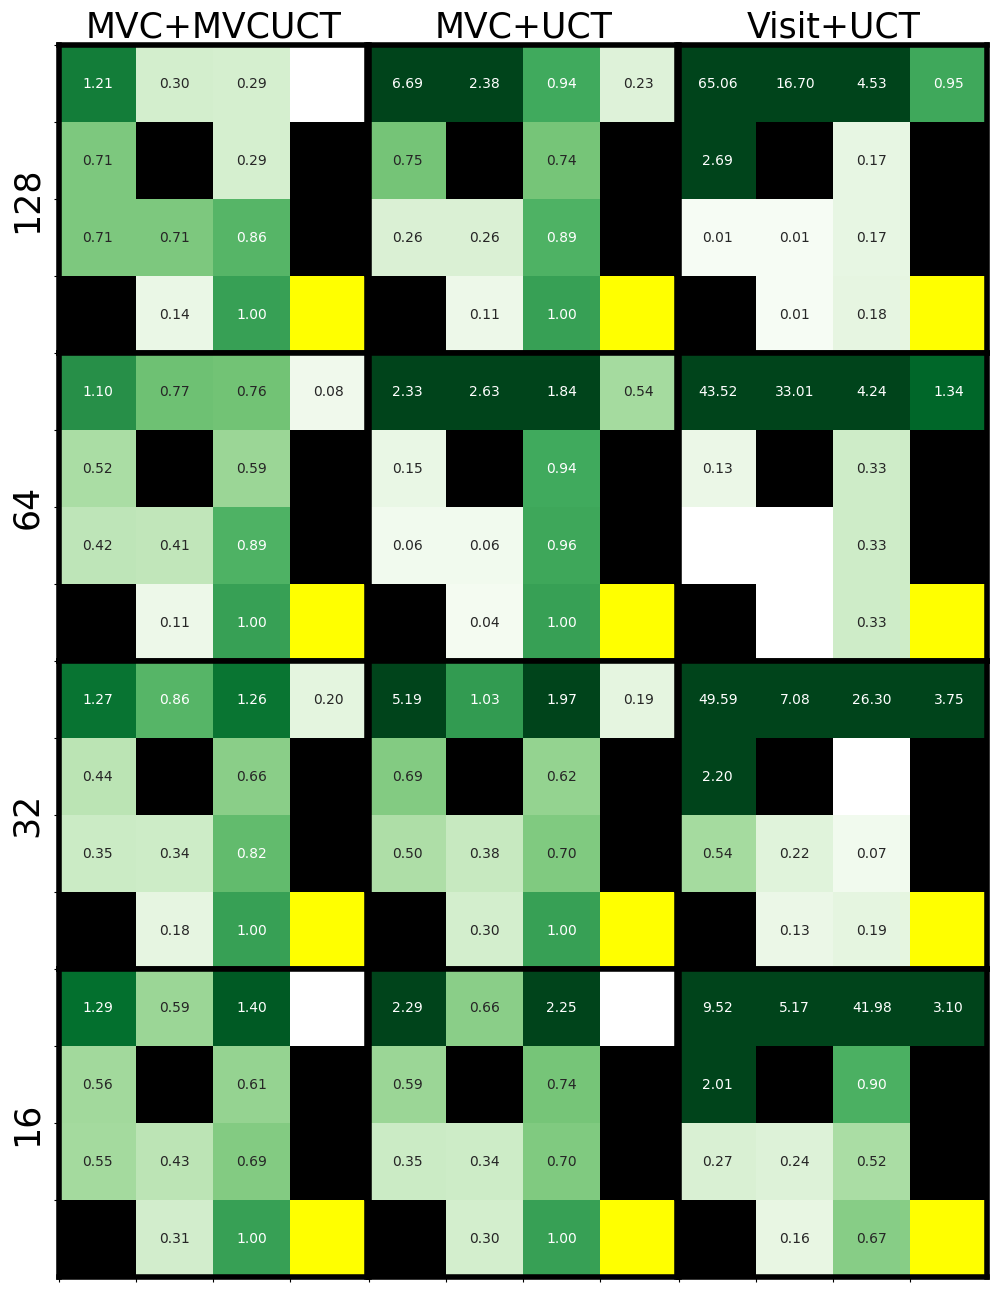

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density
# Define the frozen lake map
lake_map = df["env_params"][0]["desc"]


# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Get the number of rows and columns from the map
nrows = len(lake_map)
ncols = len(lake_map[0])

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Cliff and goal state coordinates
cliff_coords = [(r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'H']
goal_coord = next((r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'G')

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)

    # Set cliff and goal states to np.nan to hide their annotations
    for (row, col) in cliff_coords:
        density[row, col] = np.nan  # Remove numbers from the cliff cells
    goal_row, goal_col = goal_coord
    density[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell

    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs

    # Create a custom colormap to highlight cliff and goal
    cmap = sns.color_palette("Greens", as_cmap=True)

    # Mask the 0.0 entries by setting them to NaN
    masked_density = density.copy()
    masked_density[masked_density == 0.0] = np.nan

    # Create a normalization instance with clip=True to ensure values above 1.5 are clipped
    norm = colors.Normalize(vmin=1e-3, vmax=1.5, clip=True)

    # Plot the heatmap
    sns.heatmap(masked_density, ax=ax, cmap=cmap, cbar=False, annot=True, fmt='.2f', mask=np.isnan(masked_density), norm=norm)

    # Highlight the cliff states with black color
    for (row, col) in cliff_coords:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    # Highlight the goal state with yellow color
    ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))

    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square

    # Set labels for the outer plots with larger font size
    if i == 0:
        ax.set_title(policy_combination, fontsize=25)
    if j == 0:
        ax.set_ylabel(f"{planning_budget}", fontsize=25)

# Adjust layout to remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Add a border around each subplot
for ax in axs.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(4)

plt.savefig("outfiles/4x4lake_heuristic_dist.pdf", bbox_inches='tight')
plt.show()


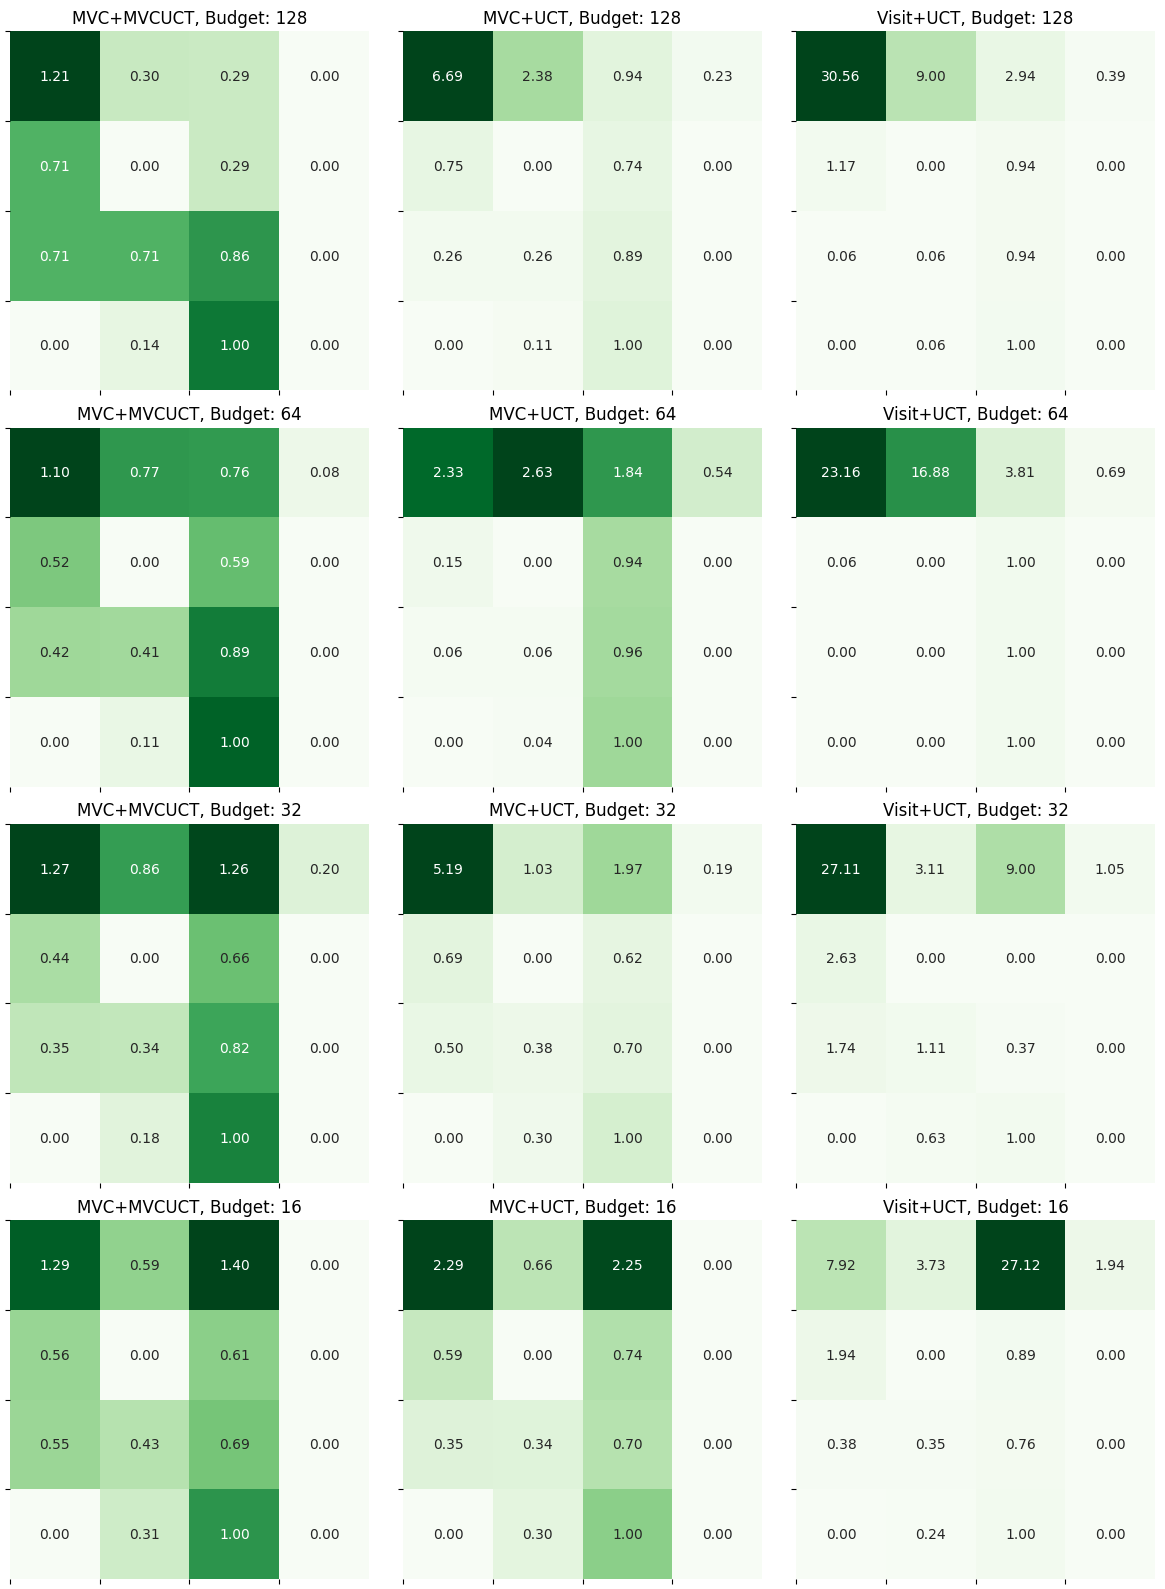

In [30]:
# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.2f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/4x4lake_heurstic_density.pdf")
plt.show()


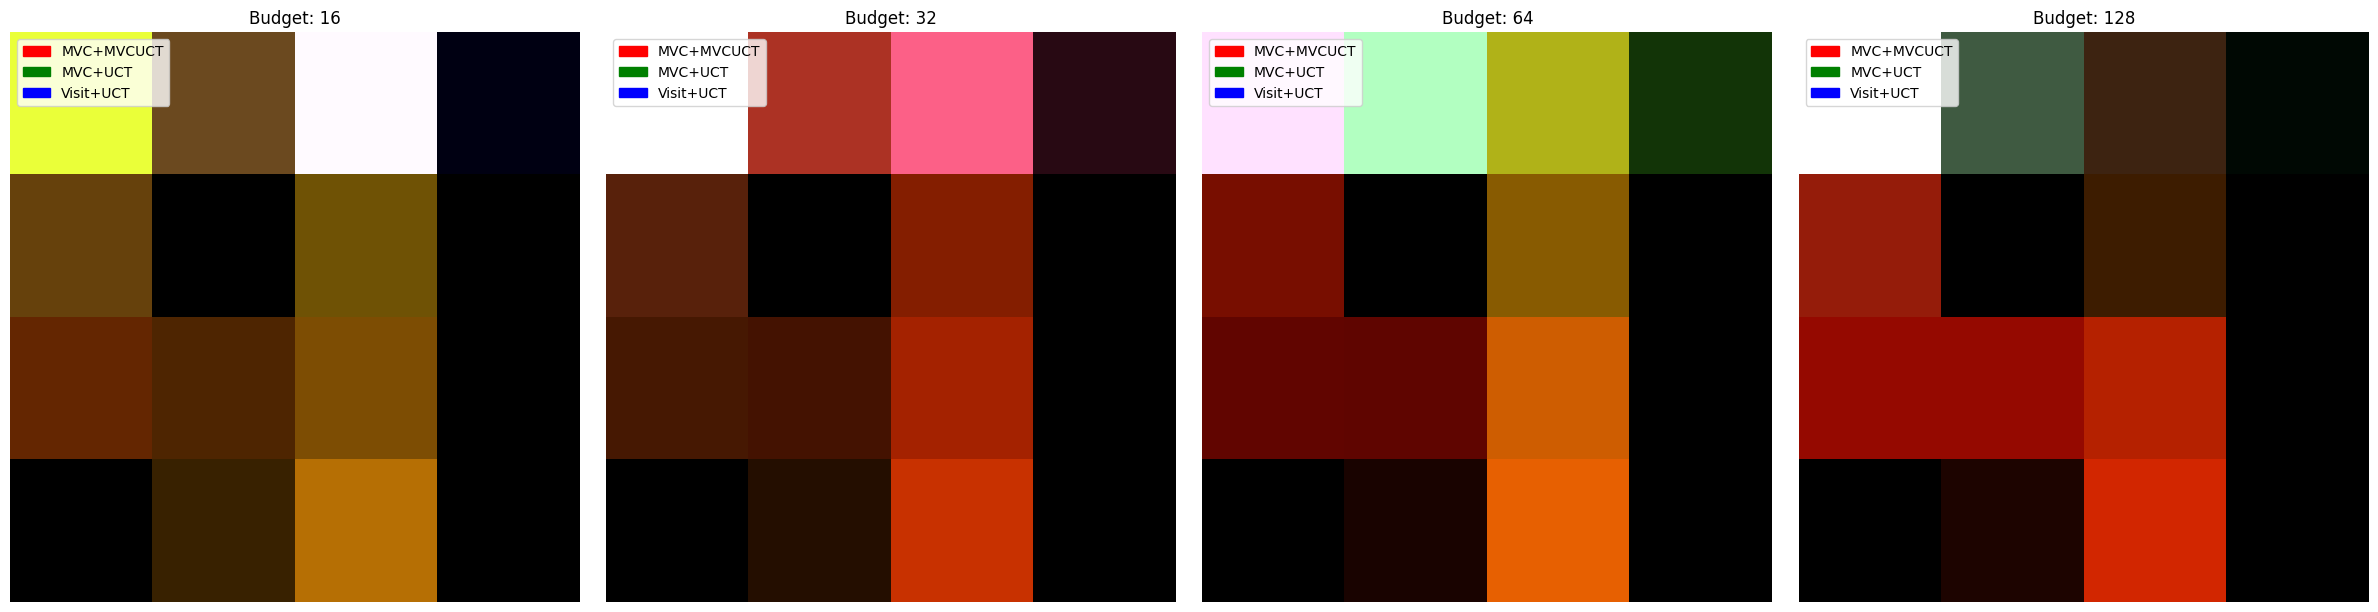

In [31]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()

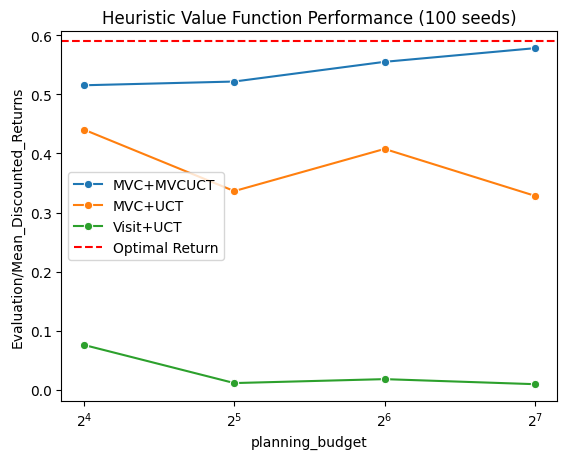

In [32]:
# plot Evaluation/Mean_Discounted_Returns from df vs planning_budget for each policy_combination

sns.lineplot(data=df, x='planning_budget', y='Evaluation/Mean_Discounted_Returns', hue='policy_combination', marker='o')
optimal_value = df["optimal_value"][0]
plt.axhline(optimal_value, color='red', linestyle='--', label='Optimal Return')
# set x axis to log2 scale
plt.xscale('log', base=2)
plt.legend()
plt.title('Heuristic Value Function Performance (100 seeds)')
plt.savefig("outfiles/4x4heuristic_value_function_performance.pdf")
plt.show()
